In [ ]:
#https://drive.google.com/file/d/1YwMNCjjA26411vAXDtdT84gwO5AxzJYF/view?usp=sharing

In [ ]:

import os
import zipfile
import random
import shutil

zip_path = '/content/drive/MyDrive/mydata.zip'
extract_path = '/content/retinopathy_dataset'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


base_dir = '/content/retinopathy_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)


classes = ['0', '1', '2', '3', '4']

for c in classes:
    for split in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(split, c), exist_ok=True)


from sklearn.model_selection import train_test_split

for c in classes:
    class_dir = os.path.join(extract_path, c)
    images = os.listdir(class_dir)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.85 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, c, img))
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(val_dir, c, img))
    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, c, img))

print("spliting done")


spliting done


In [ ]:
import os
import time
import copy
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally for data augmentation
    transforms.RandomRotation(10),  # Apply random rotation within ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly change brightness and contrast
    transforms.ToTensor(),  # Convert PIL image to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                         [0.229, 0.224, 0.225])  # Normalize using ImageNet std deviation
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.ToTensor(),  # Convert PIL image to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                         [0.229, 0.224, 0.225])  # Normalize using ImageNet std deviation
])


In [ ]:
data_dir = '/content/retinopathy_split'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['0', '1', '2', '3', '4']


In [ ]:
model = models.alexnet(pretrained=True)

# freeze all layer except classifier
for param in model.features.parameters():
    param.requires_grad = False

# update final layer to fit the 5 classes
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[6].in_features, 5)
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 88.3MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def calculate_accuracy(loader, model):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient calculation needed
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct += torch.sum(preds == labels).item()  # Count correct predictions
            total += labels.size(0)  # Total number of samples
    return correct / total  # Return accuracy


In [ ]:
import time
import copy
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs=15, patience=5):
    since = time.time()  # Start timing
    best_model_wts = copy.deepcopy(model.state_dict())  # Save initial weights
    best_val_acc = 0.0
    best_test_acc = 0.0
    epochs_no_improve = 0  # For early stopping

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    all_preds_final = []
    all_labels_final = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predictions
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)  # Accumulate loss
            running_corrects += torch.sum(preds == labels.data)  # Count correct predictions

            all_preds_final.append(preds.cpu().numpy())  # Save predictions
            all_labels_final.append(labels.cpu().numpy())  # Save true labels

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        val_acc = calculate_accuracy(val_loader, model)  # Validation accuracy
        test_acc = calculate_accuracy(test_loader, model)  # Test accuracy

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f'>> Epoch {epoch+1} Summary:')
        print(f'   Train Loss: {epoch_loss:.4f}')
        print(f'   Train Acc : {epoch_acc:.4f}')
        print(f'   Val Acc   : {val_acc:.4f}')
        print(f'   Test Acc  : {test_acc:.4f}')

        scheduler.step(val_acc)  # Step the scheduler

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    time_elapsed = time.time() - since
    print(f'\nTraining completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_val_acc:.4f}')
    print(f'Corresponding Test Acc: {best_test_acc:.4f}')

    model.load_state_dict(best_model_wts)  # Load best model

    return model, all_preds_final, all_labels_final, train_losses, train_accuracies, val_accuracies, best_val_acc, best_test_acc


In [ ]:
model, all_preds, all_labels, train_losses, train_accs, val_accs, best_val_acc, best_test_acc = train_model(model, criterion, optimizer, scheduler)



Epoch 1/15
>> Epoch 1 Summary:
   Train Loss: 0.9185
   Train Acc : 0.7260
   Val Acc   : 0.7348
   Test Acc  : 0.7346

Epoch 2/15
>> Epoch 2 Summary:
   Train Loss: 0.8751
   Train Acc : 0.7317
   Val Acc   : 0.7363
   Test Acc  : 0.7355

Epoch 3/15
>> Epoch 3 Summary:
   Train Loss: 0.8651
   Train Acc : 0.7340
   Val Acc   : 0.7352
   Test Acc  : 0.7346

Epoch 4/15
>> Epoch 4 Summary:
   Train Loss: 0.8533
   Train Acc : 0.7347
   Val Acc   : 0.7367
   Test Acc  : 0.7357

Epoch 5/15
>> Epoch 5 Summary:
   Train Loss: 0.8499
   Train Acc : 0.7345
   Val Acc   : 0.7367
   Test Acc  : 0.7350

Epoch 6/15
>> Epoch 6 Summary:
   Train Loss: 0.8495
   Train Acc : 0.7338
   Val Acc   : 0.7365
   Test Acc  : 0.7350

Epoch 7/15
>> Epoch 7 Summary:
   Train Loss: 0.8430
   Train Acc : 0.7353
   Val Acc   : 0.7365
   Test Acc  : 0.7357

Epoch 8/15
>> Epoch 8 Summary:
   Train Loss: 0.8194
   Train Acc : 0.7377
   Val Acc   : 0.7373
   Test Acc  : 0.7352

Epoch 9/15
>> Epoch 9 Summary:
   Train


 Classification Report:
              precision    recall  f1-score   support

           0     0.7452    0.9972    0.8530      3872
           1     0.0000    0.0000    0.0000       367
           2     0.4643    0.0164    0.0316       794
           3     0.4667    0.0534    0.0959       131
           4     0.4681    0.2056    0.2857       107

    accuracy                         0.7405      5271
   macro avg     0.4289    0.2545    0.2532      5271
weighted avg     0.6385    0.7405    0.6395      5271



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


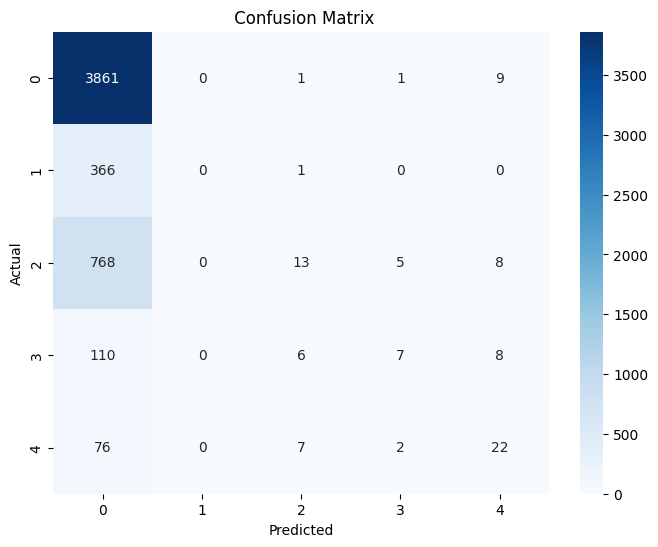

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model and calculate advanced metrics
def evaluate_metrics(model, loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(" Confusion Matrix")
    plt.show()

# Class names (according to the folder order inside ImageFolder)
class_names = train_dataset.classes  # Or set manually: ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

# Run evaluation on the test_loader
evaluate_metrics( model , test_loader, class_names=class_names)


In [ ]:
!pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Convergence Delta: -0.0341


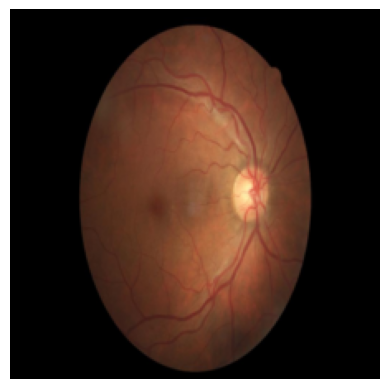

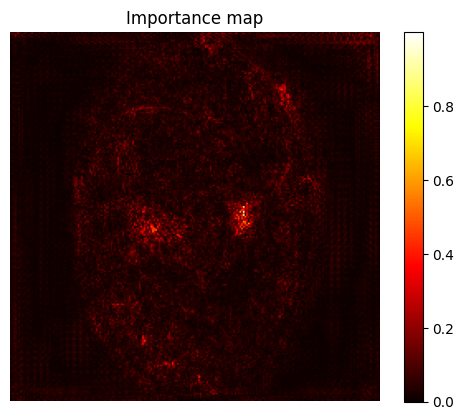

In [ ]:
import torch
from torchvision import datasets, transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
import random

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model and modify output layer
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 5)

model = model.to(device)
model.eval()  # Set model to eval mode

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(
    '/content/retinopathy_split/test',  # Update this path as needed
    transform=transform
)

# Function to show the original image
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to show attribution map
def visualize_attr(attr):
    attr = attr.cpu().detach().numpy()

    if attr.ndim == 4:
        attr = attr.squeeze(0)
    if attr.ndim == 3 and attr.shape[0] == 1:
        attr = attr.squeeze(0)
    elif attr.ndim == 3 and attr.shape[0] == 3:
        attr = attr.transpose(1, 2, 0)
        attr = np.sum(np.abs(attr), axis=2)
    elif attr.ndim == 2:
        pass
    else:
        raise ValueError(f"Unexpected shape: {attr.shape}")

    # Normalize
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

    plt.imshow(attr, cmap='hot')
    plt.colorbar()
    plt.axis('off')
    plt.title('Importance map')
    plt.show()

# Pick random image from test set
idx = random.randint(0, len(test_dataset)-1)
image, label = test_dataset[idx]
image = image.to(device)
label = torch.tensor(label).to(device)

# Integrated Gradients
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(
    inputs=image.unsqueeze(0),  # Add batch dimension
    target=label,
    return_convergence_delta=True
)

print(f"Convergence Delta: {delta.item():.4f}")
show_image(image)            # Show original image
visualize_attr(attributions) # Show attribution map


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


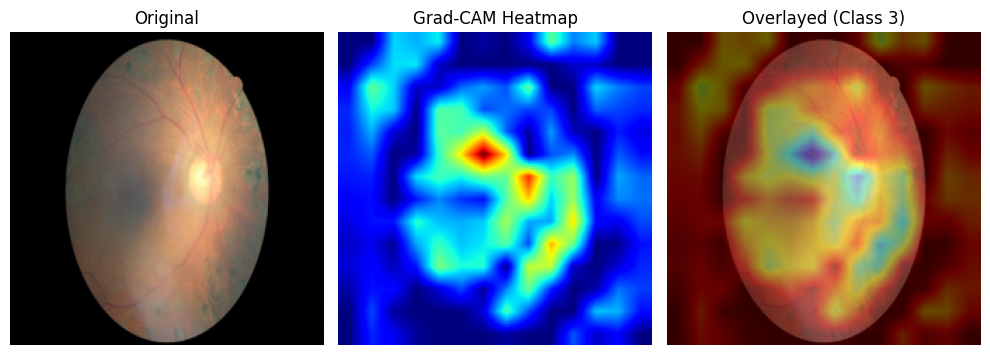

In [ ]:
# Load required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set model to evaluation mode
model.eval()

# Select the last convolutional layer in AlexNet
target_layer = model.features[12]

# Grad-CAM class definition
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()  # Register forward and backward hooks

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()  # Save forward activations

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()  # Save gradients from backward pass

        # Attach hooks to the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()  # Clean up hooks

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()  # Use predicted class if none provided

        target = output[0, class_idx]
        target.backward()  # Backward pass to compute gradients

        # Average gradients across the spatial dimensions
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        # Weight the activations by the corresponding gradients
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        # Compute heatmap
        heatmap = torch.mean(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)  # ReLU
        heatmap /= torch.max(heatmap)  # Normalize
        return heatmap.numpy(), class_idx

# Load and preprocess the input image
image_path = '/content/retinopathy_dataset/4/10017_right.jpeg'
img = Image.open(image_path).convert('RGB')
input_tensor = val_test_transforms(img).unsqueeze(0).to(device)

# Generate Grad-CAM heatmap
gradcam = GradCAM(model, target_layer)
heatmap, pred_class = gradcam.generate(input_tensor)

# Prepare image and heatmap for visualization
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

# Display original image, heatmap, and overlay
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Overlayed (Class {pred_class})")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Remove hooks after visualization
gradcam.remove_hooks()


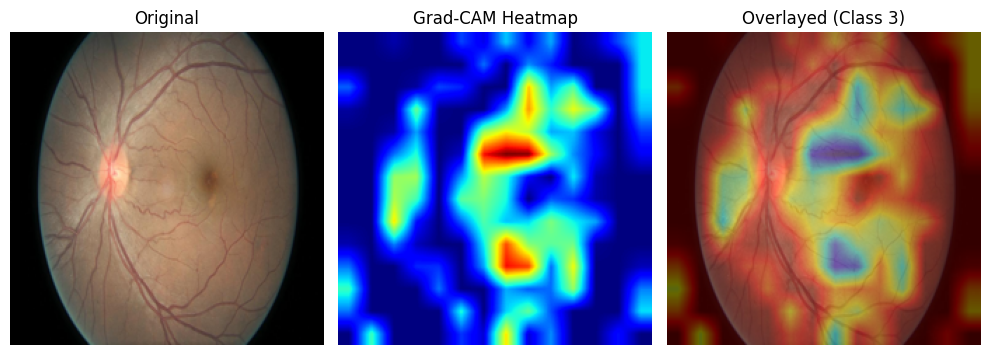

In [ ]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

# Set the model to evaluation mode (important for inference)
model.eval()

# Select the target convolutional layer for Grad-CAM (last conv layer)
target_layer = model.features[12]

# Define the Grad-CAM class to compute heatmaps
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()  # Register forward and backward hooks

    def _register_hooks(self):
        # Save feature maps from the forward pass
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Save gradients from the backward pass
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Attach hooks to the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    # Remove hooks after use to free memory
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    # Generate Grad-CAM heatmap
    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()  # Clear gradients
        output = self.model(input_tensor)  # Forward pass

        # If class not provided, use the predicted class
        if class_idx is None:
            class_idx = output.argmax().item()

        # Compute gradients with respect to the target class
        target = output[0, class_idx]
        target.backward()

        # Global average pooling on gradients
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        # Weight each channel in the activation map
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        # Average the weighted activation maps to get the heatmap
        heatmap = torch.mean(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)  # ReLU
        heatmap /= torch.max(heatmap)  # Normalize to [0, 1]
        return heatmap.numpy(), class_idx

# Load and preprocess the image
image_path = '/content/retinopathy_dataset/0/10009_right.jpeg'  # Path to input image
img = Image.open(image_path).convert('RGB')  # Load image as RGB

# Transform the image as required by the model
input_tensor = val_test_transforms(img).unsqueeze(0).to(device)

# Create Grad-CAM object and generate heatmap
gradcam = GradCAM(model, target_layer)
heatmap, pred_class = gradcam.generate(input_tensor)

# Resize and prepare heatmap for visualization
img_np = np.array(img.resize((224, 224)))  # Convert PIL to numpy array
heatmap = cv2.resize(heatmap, (224, 224))  # Resize heatmap to match image
heatmap = np.uint8(255 * heatmap)  # Scale heatmap to [0, 255]
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map
superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)  # Overlay

# Plot original image, heatmap, and overlayed result
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Overlayed (Class {pred_class})")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Remove hooks after use
gradcam.remove_hooks()


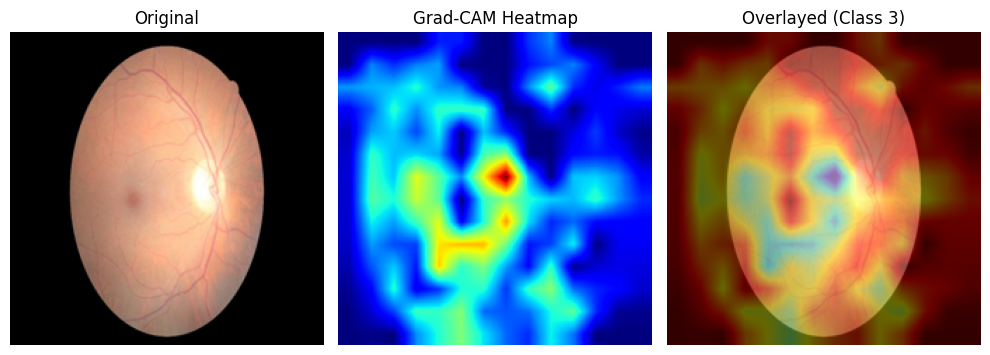

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

# Set the model to evaluation mode (important for inference)
model.eval()

# Select the target convolutional layer (usually last conv layer before classifier)
target_layer = model.features[12]

# Define Grad-CAM class to compute class activation heatmaps
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None  # Store gradients from backward pass
        self.activations = None  # Store feature maps from forward pass
        self.hook_handles = []
        self._register_hooks()  # Attach hooks to capture activations and gradients

    def _register_hooks(self):
        # Hook for forward pass to save activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Hook for backward pass to save gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Register hooks on the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    # Remove hooks after use to free resources
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    # Generate Grad-CAM heatmap for a given input and target class
    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()  # Clear previous gradients
        output = self.model(input_tensor)  # Forward pass

        # If no class specified, use the predicted class
        if class_idx is None:
            class_idx = output.argmax().item()

        target = output[0, class_idx]
        target.backward()  # Compute gradients for the target class

        # Average gradients spatially to get importance weights
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        # Weight the activations by their importance
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        # Average weighted activations across channels to create heatmap
        heatmap = torch.mean(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)  # Apply ReLU to keep positive influence only
        heatmap /= torch.max(heatmap)  # Normalize heatmap between 0 and 1
        return heatmap.numpy(), class_idx

# Load and preprocess an image from test set 1
image_path = '/content/retinopathy_dataset/1/10169_right.jpeg'  # Specify image path
img = Image.open(image_path).convert('RGB')  # Load image as RGB

# Apply the same transformations used during validation/testing
input_tensor = val_test_transforms(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Initialize Grad-CAM with the model and target layer
gradcam = GradCAM(model, target_layer)
heatmap, pred_class = gradcam.generate(input_tensor)  # Generate heatmap and predicted class

# Prepare the image and heatmap for visualization
img_np = np.array(img.resize((224, 224)))  # Resize image for display
heatmap = cv2.resize(heatmap, (224, 224))  # Resize heatmap to match image size
heatmap = np.uint8(255 * heatmap)  # Convert heatmap to 8-bit format
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map for better visibility
superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)  # Overlay heatmap on original image

# Plot original image, heatmap, and overlayed result side by side
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.title(f"Overlayed (Class {pred_class})")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Clean up hooks to avoid memory leaks
gradcam.remove_hooks()
